<a href="https://colab.research.google.com/github/PseudoPythonista/deep_learning/blob/master/dog_classifier_resnet154.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from __future__ import print_function, division
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import copy

%matplotlib inline

In [ ]:
resnet = models.resnet152(pretrained=True)
resnet

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
#data
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [ ]:
root = '/content/drive/My Drive/pytorch/DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'val'), transform=test_transform)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Iris

Label: [ 17 109  53  59   7  97  68  59  87  69]
Class: Border_terrier Tibetan_terrier Greater_Swiss_Mountain_dog Irish_wolfhound Basenji Scottish_deerhound Lakeland_terrier Irish_wolfhound Pomeranian Leonberg


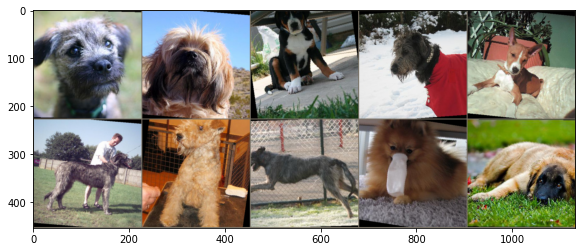

In [ ]:

for images,labels in train_loader: 
    break

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [ ]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 119) # edit last layer: 119 possible breeds

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

if torch.cuda.is_available():
    resnet = resnet.cuda()
    criterion = criterion.cuda()

In [ ]:
start_time = time.time()

epochs = 2

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if torch.cuda.is_available():
          X_train = X_train.cuda()
          y_train = y_train.cuda()
        if b == max_trn_batch:
            break
        b+=1
        
        y_pred = resnet(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1] #sum up preds
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad() #update params
        loss.backward()
        optimizer.step()

        if b%200 == 0: #tracking

            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
            accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad(): #testing batches
        for b, (X_test, y_test) in enumerate(test_loader):
          if torch.cuda.is_available():
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            if b == max_tst_batch:
                break

            y_val = resnet(X_test.cuda())

            predicted = torch.max(y_val.data, 1)[1] #sum up the preds
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 1.68703628  accuracy:  32.150%
epoch:  0  batch:  400 [  4000/8000]  loss: 1.74700797  accuracy:  47.325%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.49826521  accuracy:  54.267%
epoch:  0  batch:  800 [  8000/8000]  loss: 1.50564611  accuracy:  58.638%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.44555408  accuracy:  72.900%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.25085792  accuracy:  73.075%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.54117972  accuracy:  73.017%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.80094403  accuracy:  73.338%

Duration: 331 seconds


Predicted value: 49 Golden_retriever


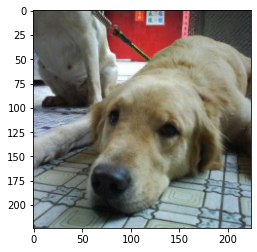

In [ ]:
#select a custom image
x = 2099
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
resnet.eval()
with torch.no_grad():
    new_pred = resnet(test_data[x][0].view(1,3,224,224).cuda()).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

In [ ]:
#custom imgs
custom_test = datasets.ImageFolder("/content/drive/My Drive/pytorch/CUSTOM_DOGS/CUSTOM_TEST",transform=test_transform)

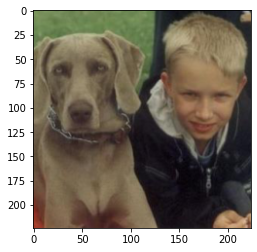

In [ ]:
pic_nums = np.arange(4)
for pic in pic_nums:
  im = inv_normalize(custom_test[pic][0])
  plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))


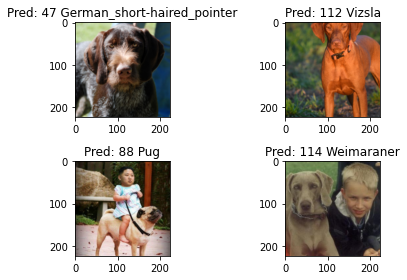

In [ ]:
width=5
height=5
rows = 2
cols = 2
axes=[]
fig=plt.figure()
for pic in pic_nums:
  with torch.no_grad():
    new_pred = resnet(custom_test[pic][0].view(1,3,224,224).cuda()).argmax()
  im = inv_normalize(custom_test[pic][0])
  axes.append( fig.add_subplot(rows, cols, pic+1) )
  subplot_title=(f'Pred: {new_pred.item()} {class_names[new_pred.item()]}')
  axes[-1].set_title(subplot_title)  
  plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
fig.tight_layout()    
plt.show()

In [ ]:
#save the model
torch.save(resnet.state_dict(), 'RESNET154-DOG-CNN-Model.pt')

In [ ]:
test_load_all = DataLoader(test_data, batch_size=100, shuffle=True)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
      if torch.cuda.is_available():
        X_test = X_test.cuda()
        y_test = y_test.cuda()
        y_val = resnet(X_test.cuda())
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 4190/5131 =  81.660%


Some incorrectly predicted breeds:

Correct breed:  Schipperke Standard_schnauzer Schipperke Miniature_pinscher Komondor Standard_schnauzer Briard
Breed guessed:  Shetland_sheepdog Miniature_schnauzer Miniature_pinscher Chihuahua Old_English_sheepdog Miniature_schnauzer Cairn


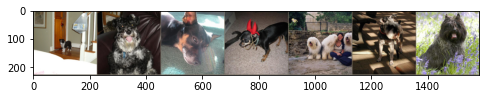

In [ ]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')

r = 8
row = iter(np.array_split(misses,len(misses)//r+1))

np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

nextrow = next(row)
lbls = y_test.cpu().index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.cpu().index_select(0,torch.tensor(nextrow)).numpy()
print("Some incorrectly predicted breeds:")
print()
print("Correct breed: ", *np.array([class_names[i] for i in gues]))
print("Breed guessed: ", *np.array([class_names[i] for i in lbls]))
images = X_test.cpu().index_select(0,torch.tensor(nextrow))
im = inv_normalize(make_grid(images, nrow=r))
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));       